# Visualize Results
---

## Load Required Data

In [15]:
# load model
from tensorflow import keras

model = keras.models.load_model('../CICIDS2017/models/ids_dnn.keras')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 50)             │         3,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,238 (63.43 KB)

 Trainable params: 5,412 (21.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,826 (42.29 KB)

In [2]:
import pandas as pd

X_train = pd.read_csv("../CICIDS2017/train_test_split/X_train_proto.csv")
X_test = pd.read_csv("../CICIDS2017/train_test_split/X_test_proto.csv")
y_train = pd.read_csv("../CICIDS2017/train_test_split/y_train_proto.csv")
y_test = pd.read_csv("../CICIDS2017/train_test_split/y_test_proto.csv")

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 70) (2000, 70) (8000, 2) (2000, 2)


In [3]:
# load adversarial sample
X_test_adv_fgsm = pd.read_csv("../CICIDS2017/adversarial_samples/X_test_adv_fgsm_proto.csv")
X_test_adv_cw = pd.read_csv("../CICIDS2017/adversarial_samples/X_test_small_adv_cw.csv")
X_test_adv_hsj = pd.read_csv("../CICIDS2017/adversarial_samples/X_test_adv_hsj_proto.csv")

In [16]:
# load explanations
shap_values_df = pd.read_csv("../CICIDS2017/shap_values/shap_values_proto.csv")
adv_shap_values_fgsm_df = pd.read_csv("../CICIDS2017/shap_values/adv_shap_values_fgsm_proto.csv")
adv_shap_values_hsj_df = pd.read_csv("../CICIDS2017/shap_values/adv_shap_values_hsj_proto.csv")
adv_shap_values_cw_df = pd.read_csv("../CICIDS2017/shap_values/adv_shap_values_cw_proto.csv")

---

## Find Important and Misclassified Data for Visualization

### Predict on Data to find Misclassification

In [5]:
import numpy as np

print("Correct Labels:")
y_test_np = np.array(y_test).argmin(axis=1)
print(f"Prediction: {y_test_np[:20]}")

# predict samples
print("Prediction on clean samples...")
y_pred = model.predict(X_test)
print("convert to binary...")
print(y_pred.shape)
y_pred = y_pred.argmin(axis=1) # convert to binary, 1 == benign, 0 == malicious
print(y_pred.shape)
print(f"Prediction: {y_pred[:20]}")

print("Prediction on FGSM attacked samples...")
y_pred_adv_fgsm = model.predict(X_test_adv_fgsm)
y_pred_adv_fgsm = y_pred_adv_fgsm.argmin(axis=1) # convert to binary, 1 == benign, 0 == malicious
print(f"Prediction: {y_pred_adv_fgsm[:20]}")

print("Prediction on CW attacked samples...")
y_pred_adv_cw = model.predict(X_test_adv_cw)
y_pred_adv_cw = y_pred_adv_cw.argmin(axis=1) # convert to binary, 1 == benign, 0 == malicious
print(f"Prediction: {y_pred_adv_cw[:20]}")

print("Prediction on Hop Skip Jump attacked samples...")
y_pred_adv_hsj = model.predict(X_test_adv_hsj)
y_pred_adv_hsj = y_pred_adv_hsj.argmin(axis=1) # convert to binary, 1 == benign, 0 == malicious
print(f"Prediction: {y_pred_adv_hsj[:20]}")

Correct Labels:
Prediction: [1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1]
Prediction on clean samples...


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
convert to binary...
(2000, 2)
(2000,)
Prediction: [1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1]
Prediction on FGSM attacked samples...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
Prediction: [1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1]
Prediction on CW attacked samples...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
Prediction: [1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1]
Prediction on Hop Skip Jump attacked samples...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
Prediction: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


### Find Misclassified Samples due to CW Attack

In [6]:
# Find correctly classified indices
correctly_classified_indices = np.where(y_test_np == y_pred)[0]

# Find indices where attack misclassifies a `1` as `0`
false_negative_indices_cw = correctly_classified_indices[
    (y_test_np[correctly_classified_indices] == 1) & (y_pred_adv_cw[correctly_classified_indices] == 0)
]
print(f"CW: Misclassify Begnin Traffic as Malicious: {false_negative_indices_cw[:10]}")
print(f"Size: {np.size(false_negative_indices_cw)}")

# Find indices where attack misclassifies a `0` as `1`
false_positive_indices_cw = correctly_classified_indices[
    (y_test_np[correctly_classified_indices] == 0) & (y_pred_adv_cw[correctly_classified_indices] == 1)
]
print(f"CW: Misclassify Malicious Traffic as Benign: {false_positive_indices_cw[:10]}")
print(f"Size: {np.size(false_positive_indices_cw)}")

# all misclassified samples
misclassified_adversarial_indices = np.concat([false_negative_indices_cw, false_positive_indices_cw])
print(f"CW: All Missclassified Samples after Attack: {np.size(misclassified_adversarial_indices)}")

CW: Misclassify Begnin Traffic as Malicious: [  1  29  74 225 274 316 401 430 581 619]
Size: 24
CW: Misclassify Malicious Traffic as Benign: [ 15  71 119 135 221 228 248 266 393 432]
Size: 81
CW: All Missclassified Samples after Attack: 105


### Revert Normalization Function

In [7]:
min_max_df = pd.read_csv('../CICIDS2017/preprocessed/min_max_values.csv')
min_max = min_max_df.to_numpy()
# get second column (min values) from three column array
min_values = min_max[:, 1]
max_values = min_max[:, 2]

def revert_min_max_normalization(data):
    return data * (max_values - min_values) + max_values

# load feature_types.npy
feature_types = np.load('../CICIDS2017/preprocessed/feature_types.npy', allow_pickle=True)

def round_if_int(data, index):
    for i, col_type in enumerate(feature_types):
        if col_type == np.int64:
            data[index, i] = int(round(data[index, i]))
    return data

### Revert Normalization on Misclassified Data

In [8]:
index = 228 # Index where CW attack misclassifies malicious traffic as benign

normal_df = X_test.copy()
normal_df = revert_min_max_normalization(normal_df)
data = round_if_int(normal_df.to_numpy(), index)
data = pd.DataFrame(data, columns=normal_df.columns)

adv_df = X_test_adv_cw.copy()
adv_df = revert_min_max_normalization(adv_df)
data_adv = round_if_int(adv_df.to_numpy(), index)
data_adv = pd.DataFrame(data_adv, columns=adv_df.columns)

### Compare Normal and Adversarial Data on Misclassification

In [9]:
# data[[' PSH Flag Count', ' Destination Port', ' ACK Flag Count', ' Min Packet Length', ' Bwd Packets/s', ' Bwd Packet Length Min', ' Bwd Packet Length Std', ' Average Packet Size']] # top 8 features
ids_prediction_values = data[[' PSH Flag Count', ' Destination Port', ' ACK Flag Count', ' Min Packet Length', ' Bwd Packets/s', ' Bwd Packet Length Min', ' Bwd Packet Length Std', ' Average Packet Size', ' Flow IAT Max', 'Init_Win_bytes_forward']]
print(ids_prediction_values.iloc[index])
print("--VS--")
ids_prediction_values_adv = data_adv[[' PSH Flag Count', ' Destination Port', ' ACK Flag Count', ' Min Packet Length', ' Bwd Packets/s', ' Bwd Packet Length Min', ' Bwd Packet Length Std', ' Average Packet Size', ' Flow IAT Max', 'Init_Win_bytes_forward']]
print(ids_prediction_values_adv.iloc[index])

# get prediction with confidence
normal_sample = X_test.iloc[index]
normal_sample = normal_sample.to_numpy().reshape(1, -1)
normal_prediction = model.predict(normal_sample)
confidence = normal_prediction.max()
normal_prediction = normal_prediction[0]
normal_prediction = normal_prediction.argmin()
print(f"Normal Prediction: {normal_prediction}")
print(f"Confidence: {confidence*100:.2f}%")

adversarial_sample = X_test_adv_cw.iloc[index]
adversarial_sample = adversarial_sample.to_numpy().reshape(1, -1)
adversarial_prediction = model.predict(adversarial_sample)
confidence = adversarial_prediction.max()
adversarial_prediction = adversarial_prediction[0]
adversarial_prediction = adversarial_prediction.argmin()
print(f"Adversarial Prediction: {adversarial_prediction}")
print(f"Confidence: {confidence*100:.2f}%")


 PSH Flag Count                     1
 Destination Port               65615
 ACK Flag Count                     2
 Min Packet Length               1454
 Bwd Packets/s              2000000.0
 Bwd Packet Length Min           2896
 Bwd Packet Length Std    8194.660487
 Average Packet Size      3900.833333
 Flow IAT Max               120037033
Init_Win_bytes_forward          65792
Name: 228, dtype: object
--VS--
 PSH Flag Count                        1
 Destination Port                  65624
 ACK Flag Count                        2
 Min Packet Length                  1458
 Bwd Packets/s            2000001.013279
 Bwd Packet Length Min              2896
 Bwd Packet Length Std       8194.664639
 Average Packet Size         3901.145194
 Flow IAT Max                  120036213
Init_Win_bytes_forward             65795
Name: 228, dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Normal Prediction: 0
Confidence: 91.77%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Adversarial Prediction: 1
Confidence:

---

## Visualize Data

### Differences of Normal Data

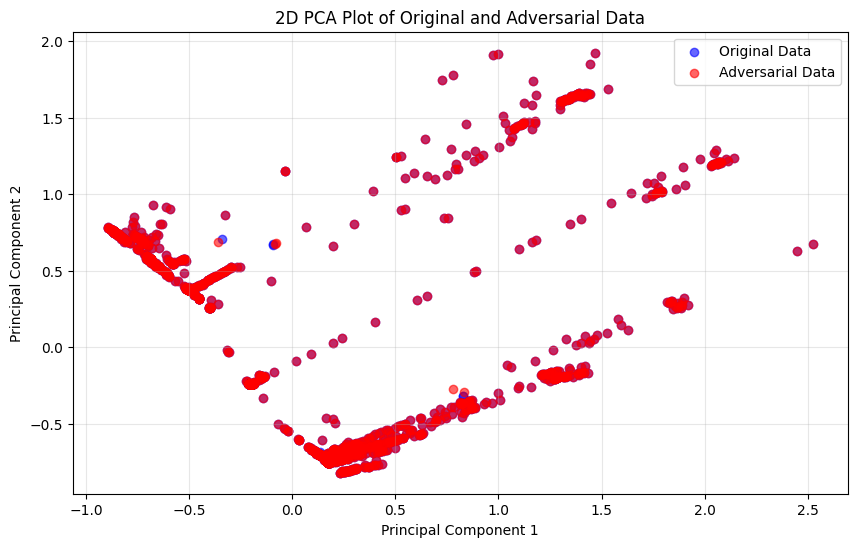

In [10]:
# Plot normal and adversarial data over each other
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA with 2 components
pca = PCA(n_components=2)
data_pca = pca.fit_transform(X_test)      # Fit and transform original data
data_adv_pca = pca.transform(X_test_adv_cw)  # Transform adversarial data (using same PCA)

# Extract Principal Components
pc1_data, pc2_data = data_pca[:, 0], data_pca[:, 1]
pc1_adv, pc2_adv = data_adv_pca[:, 0], data_adv_pca[:, 1]

# Create 2D Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(pc1_data, pc2_data, color='blue', alpha=0.6, label='Original Data')
plt.scatter(pc1_adv, pc2_adv, color='red', alpha=0.6, label='Adversarial Data')

# Add labels, title, and legend
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Plot of Original and Adversarial Data')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


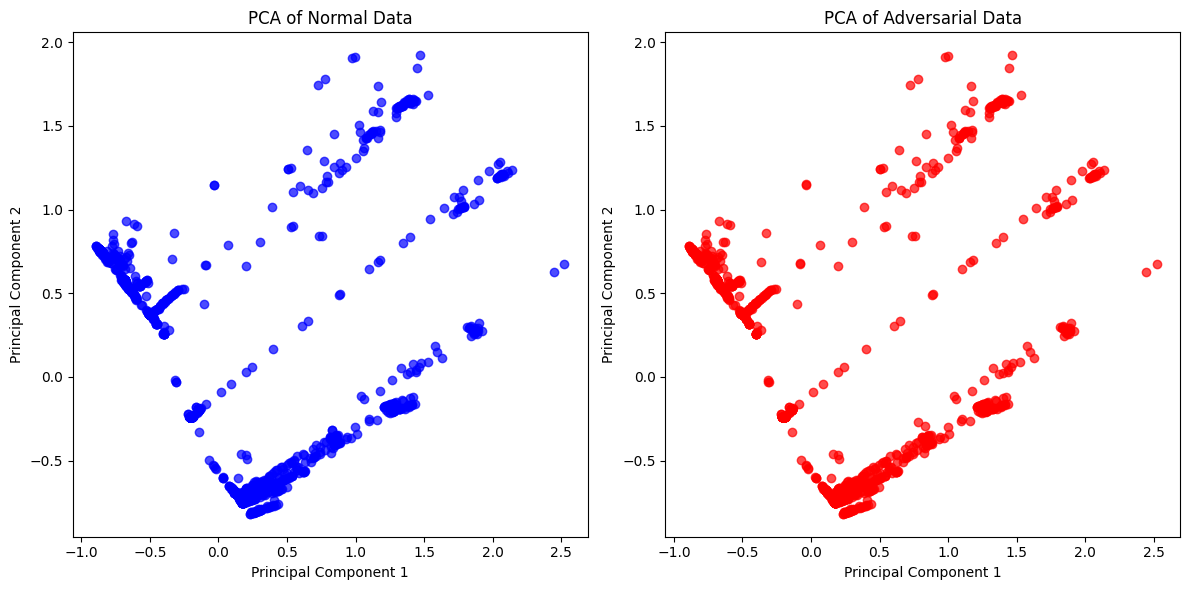

Explained variance ratio for normal data: [0.30393367 0.27109681]
Explained variance ratio for adversarial data: [0.30370743 0.27091871]


In [11]:
# Plot PCA for normal data next to adversarial data
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to normal data
pca_data = PCA(n_components=2)
data_pca = pca_data.fit_transform(X_test)

# Apply PCA to adversarial data
pca_data_adv = PCA(n_components=2)
data_adv_pca = pca_data_adv.fit_transform(X_test_adv_cw)

# Plot PCA for normal data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(data_pca[:, 0], data_pca[:, 1], color='blue', alpha=0.7)
plt.title("PCA of Normal Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Plot PCA for adversarial data
plt.subplot(1, 2, 2)
plt.scatter(data_adv_pca[:, 0], data_adv_pca[:, 1], color='red', alpha=0.7)
plt.title("PCA of Adversarial Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.tight_layout()
plt.show()

# Optional: Print explained variance ratios
print("Explained variance ratio for normal data:", pca_data.explained_variance_ratio_)
print("Explained variance ratio for adversarial data:", pca_data_adv.explained_variance_ratio_)


### Differences of SHAP Values

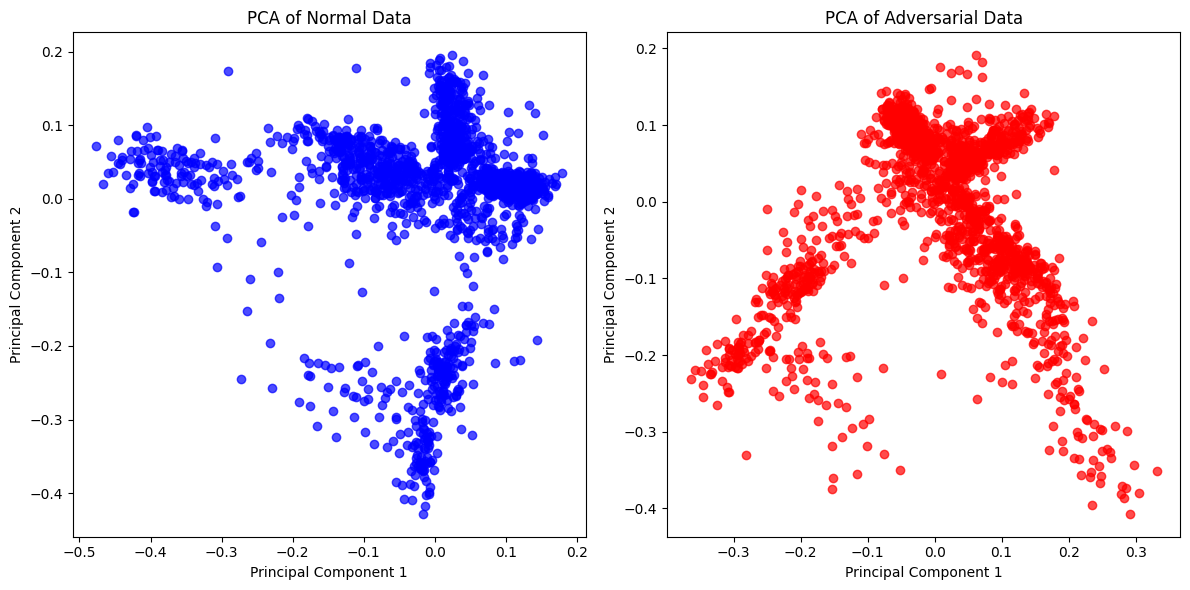

Explained variance ratio for normal data: [0.28671211 0.23541128]
Explained variance ratio for adversarial data: [0.243713   0.23652483]


In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to normal data
pca_data = PCA(n_components=2)
data_pca = pca_data.fit_transform(shap_values_df)

# Apply PCA to adversarial data
pca_data_adv = PCA(n_components=2)
data_adv_pca = pca_data_adv.fit_transform(adv_shap_values_cw_df)

# Plot PCA for normal data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(data_pca[:, 0], data_pca[:, 1], color='blue', alpha=0.7)
plt.title("PCA of Normal Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Plot PCA for adversarial data
plt.subplot(1, 2, 2)
plt.scatter(data_adv_pca[:, 0], data_adv_pca[:, 1], color='red', alpha=0.7)
plt.title("PCA of Adversarial Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.tight_layout()
plt.show()

# Optional: Print explained variance ratios
print("Explained variance ratio for normal data:", pca_data.explained_variance_ratio_)
print("Explained variance ratio for adversarial data:", pca_data_adv.explained_variance_ratio_)


---

## Show Change of Values

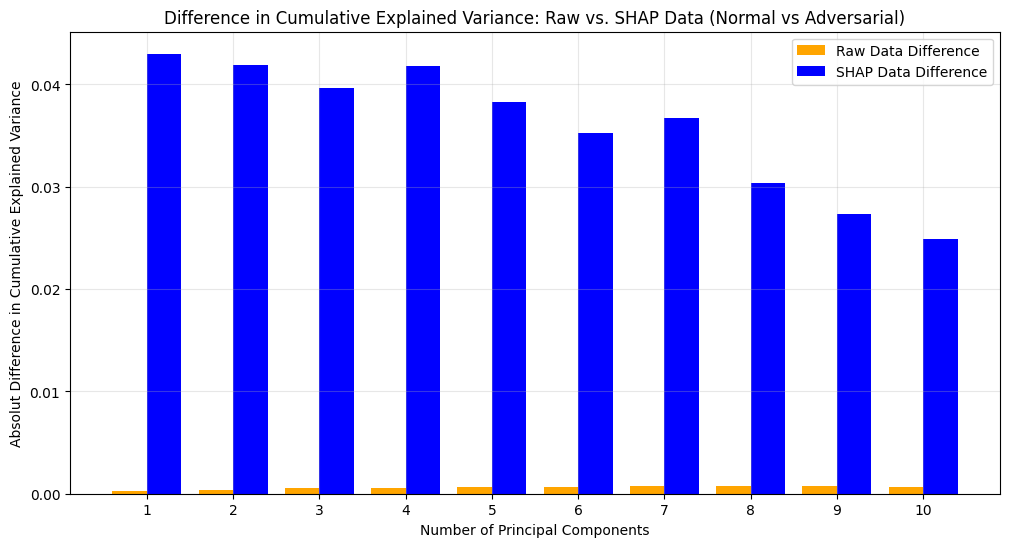

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Perform PCA for raw data (normal vs adversarial) and SHAP-transformed data (normal vs adversarial)
pca_raw_normal = PCA()
pca_raw_normal.fit(X_test)  # Normal raw data

pca_raw_adv = PCA()
pca_raw_adv.fit(X_test_adv_cw)  # Adversarial raw data

pca_shap_normal = PCA()
pca_shap_normal.fit(shap_values_df)  # Normal SHAP-transformed data

pca_shap_adv = PCA()
pca_shap_adv.fit(adv_shap_values_cw_df)  # Adversarial SHAP-transformed data

# Compute cumulative explained variance for normal and adversarial data
cumulative_variance_raw_normal = np.cumsum(pca_raw_normal.explained_variance_ratio_)[:10]
cumulative_variance_raw_adv = np.cumsum(pca_raw_adv.explained_variance_ratio_)[:10]

cumulative_variance_shap_normal = np.cumsum(pca_shap_normal.explained_variance_ratio_)[:10]
cumulative_variance_shap_adv = np.cumsum(pca_shap_adv.explained_variance_ratio_)[:10]

# Calculate the differences between normal and adversarial data for both raw and SHAP
difference_raw = np.abs(cumulative_variance_raw_adv - cumulative_variance_raw_normal)
difference_shap = np.abs(cumulative_variance_shap_adv - cumulative_variance_shap_normal)

# Create a bar plot for the differences
x = np.arange(1, 11)  # Components 1 to 10

plt.figure(figsize=(12, 6))
plt.bar(
    x - 0.2, difference_raw, width=0.4, label="Raw Data Difference", color="orange", align="center"
)
plt.bar(
    x + 0.2, difference_shap, width=0.4, label="SHAP Data Difference", color="blue", align="center"
)

# Add labels, title, legend, and grid
plt.xlabel("Number of Principal Components")
plt.ylabel("Absolut Difference in Cumulative Explained Variance")
plt.title("Difference in Cumulative Explained Variance: Raw vs. SHAP Data (Normal vs Adversarial)")
plt.xticks(ticks=x)  # Show component numbers on the x-axis
plt.legend()
plt.grid(alpha=0.3)
plt.show()


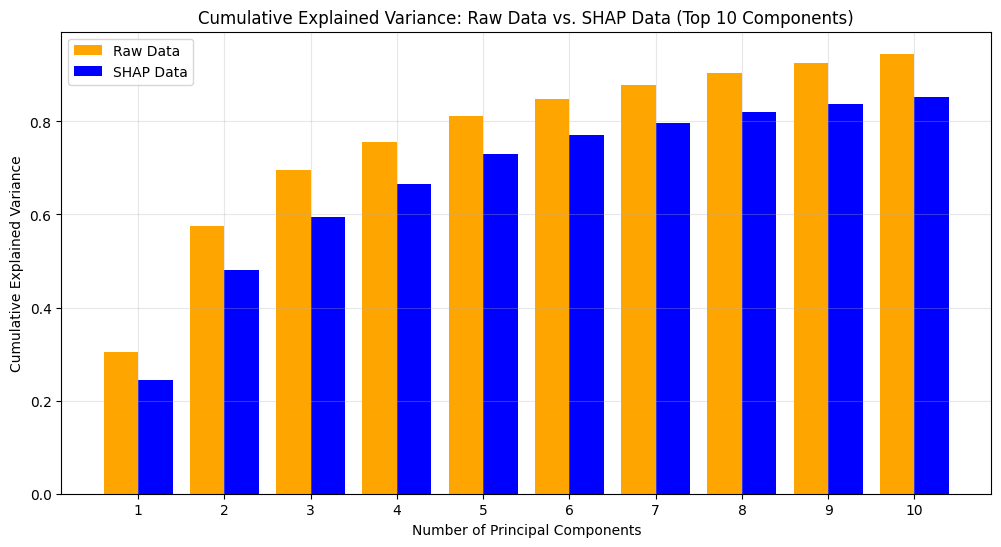

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Perform PCA for raw data and SHAP-transformed data
pca_raw = PCA()
pca_raw.fit(X_test_adv_cw)

pca_shap = PCA()
pca_shap.fit(adv_shap_values_cw_df)

# Compute cumulative explained variance for the first 10 components
cumulative_variance_raw = np.cumsum(pca_raw.explained_variance_ratio_)[:10]
cumulative_variance_shap = np.cumsum(pca_shap.explained_variance_ratio_)[:10]

# Create a bar plot for the first 10 components
x = np.arange(1, 11)  # Components 1 to 10

plt.figure(figsize=(12, 6))
plt.bar(
    x - 0.2, cumulative_variance_raw, width=0.4, label="Raw Data", color="orange", align="center"
)
plt.bar(
    x + 0.2, cumulative_variance_shap, width=0.4, label="SHAP Data", color="blue", align="center"
)

# Add labels, title, legend, and grid
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance: Raw Data vs. SHAP Data (Top 10 Components)")
plt.xticks(ticks=x)  # Show component numbers on the x-axis
plt.legend()
plt.grid(alpha=0.3)
plt.show()
